# Tracking the Cyclonic eddy sampled during the OTC23 course

This notebook is a part of the Ocean Training Course 2023, Working Group 2. It's main goal is to select and characterize the _life_ of two eddies sampled during the on board session.

<div class="alert alert-warning">
    <strong>To run this notebook, you will need:</strong>
    
* To fill directory `obs_datadir` with the a collection of cyclonic eddy detection files written by py-eddy-tracker library. For instance, using the python script _"../scripts/eddy-identification.py"_
* To fill the three dictionnaries `c_eddy1_end`, `c_eddy2_end` and `merged_start`: each of these define a point (lat,lon,time) needed to extract the desired trajectories from all  
</div>

### User options

In [5]:
# I/O options
obs_datadir = r'../../observations/duacs-nrt/adt/'
load_json   = False

# Tracks detection
merged_start = {'lon': 30.2, 'lat': -34.6, 'time': 26669.}
c_eddy1_end  = {'lon': 34.7, 'lat': -33.8, 'time': 26539.}
c_eddy2_end  = {'lon': 35.1, 'lat': -32.6, 'time': 26539.}

# logger type
logger_type = 'ERROR'   # (py-eddy-tracker) Available options: ERROR, WARNING, INFO, DEBUG

### Import necessary modules

In [6]:
import glob
import json
import os
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import datetime, timedelta
from matplotlib import pyplot as plt

from py_eddy_tracker import start_logger
from py_eddy_tracker.featured_tracking.area_tracker import AreaTracker
from py_eddy_tracker.tracking import Correspondances

start_logger().setLevel(logger_type)

### function definition

In [7]:
def select_closest_track(eddies, lon, lat, time=None):
    """select a track which pass close to a lon,lat point."""
    
    if time is None:
        nan_mask = np.ones_like(eddies.amplitude)
    else:
        cnd_time = (eddies.time == time)
        nan_mask = np.where(cnd_time, 1., np.nan)

    distance = ((eddies.lon - lon)**2. + (eddies.lat - lat)**2.)**0.5
    distance *= nan_mask

    obsindex = np.nanargmin(distance)
    track_id = eddies.tracks[obsindex]

    track    = eddies.extract_ids([track_id])
    
    return track

## 1. Run analysis

In [8]:
# First, select the cyclonic eddies track (before and after merging)
# -- all the files in 'obs_datadir' will be loaded
list_files = glob.glob(os.path.join(obs_datadir, '*'))

c = Correspondances(datasets=sorted(list_files[:]), class_method=AreaTracker, virtual=3)
c.track()
c.prepare_merging()

# -- here, we get a collection of eddies
tracked = c.merge(raw_data=False)
tracked.virtual[:] = tracked.time == 0
tracked.filled_by_interpolation(tracked.virtual == 1.)

# -- select a track which pass close to a lon,lat,time point
c_mrged_track = select_closest_track(tracked, **merged_start)
c_eddy1_track = select_closest_track(tracked, **c_eddy1_end)
c_eddy2_track = select_closest_track(tracked, **c_eddy2_end)

In [9]:
# Load syntool extracted track (can be used for comparison/validation)
syn_lons = list()
syn_lats = list()
    
if load_json:
    list_syn = glob.glob(os.path.join(obs_datadir, '../../*.json'))

    for synf in sorted(list_syn):
        with open(synf, 'r') as f:
            user_shape = json.load(f)[0]

        syn_lons.append(user_shape['center'][0])
        syn_lats.append(user_shape['center'][1])

### Plot eddy trajectories

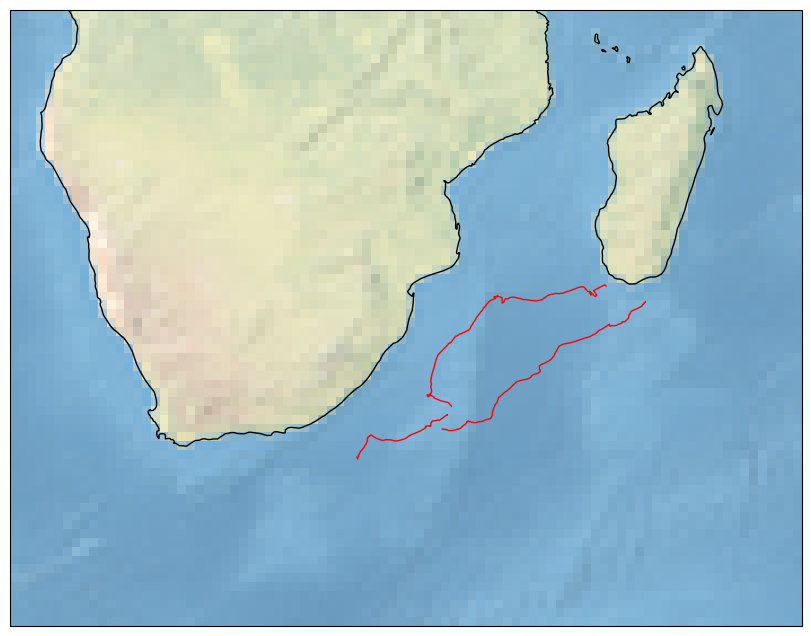

In [13]:
# Plot the eddy tracks
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([10, 55, -45, -10], crs=ccrs.PlateCarree())

# -- background image on for nice sea rendering
ax.stock_img()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

# -- add eddy track
c_mrged_track.plot(ax, color="r", lw=1)
c_eddy1_track.plot(ax, color="r", lw=1)
c_eddy2_track.plot(ax, color="r", lw=1)

#ax.plot(c_mrged_track.speed_contour_longitude[0],   c_mrged_track.speed_contour_latitude[0])
#ax.plot(c_eddy1_track.speed_contour_longitude[-1],  c_eddy2_track.speed_contour_latitude[-1],  'orange')
#ax.plot(c_eddy2_track.speed_contour_longitude[-1],  c_eddy1_track.speed_contour_latitude[-1],  'orange')
#ax.plot(c_mrged_track.speed_contour_longitude[-33], c_mrged_track.speed_contour_latitude[-33], 'green')

# -- add syntool tracks (manually exported in json files)
if load_json:
    ax.scatter(manlons[-1], manlats[-1], c="blue", s=5e0, alpha=0.75)

# -- plot/save figure
#fig.savefig('./cyclonic_eddy_tracked.png', dpi=300)

plt.show()

### Eddy characteristics evolution

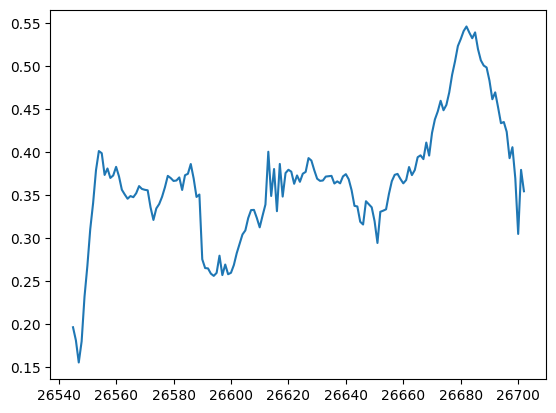

In [18]:
plt.plot(c_mrged_track.time[:], c_mrged_track.amplitude[:])

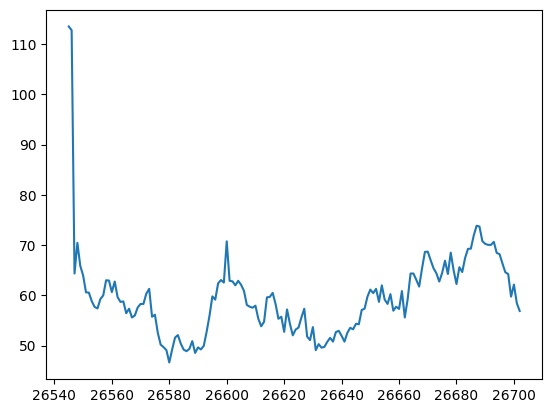

In [20]:
plt.plot(c_mrged_track.time[:], 1e-3*c_mrged_track.speed_radius[:])

In [15]:
c_mrged_track.field_table()

Name (Unit),Long name,Scale factor,Offset
amplitude (m),Amplitude,0.0001,
effective_contour_latitude (degrees_east),Effective contour latitudes,0.01,
speed_contour_latitude (degrees_east),Speed contour latitudes,0.01,
effective_contour_longitude (degrees_east),Effective contour longitudes,0.01,180.0
speed_contour_longitude (degrees_east),Speed contour longitudes,0.01,180.0
cost_association (),Cost association between two eddies,,
effective_area (m^2),Effective area,,
effective_contour_height (m),Effective contour height,,
inner_contour_height (m),Inner contour height,,
speed_contour_height (m),Speed contour height,,
